# 分类模型，任务场景：光伏面板状态分类

## 0 远程拉取项目（本地运行时不要运行这部分,可将这部分全部注释）

In [ ]:
# ===== 第 0 步：初始化项目  =====
import os

REPO_NAME = "sjtu-ML"                                    #仓库名称
REPO_URL  = "https://github.com/sihaobao/sjtu-ML.git"    #github仓库地址

# 1. 如果仓库不存在，则 clone
if not os.path.exists(f"/content/{REPO_NAME}"):
    !git clone {REPO_URL}

# 2. 切换到 google colab 中的仓库根目录
os.chdir(f"/content/{REPO_NAME}")

# 3. 切换到当前实验目录（数据就在这里）
os.chdir("第四章-分类模型")

print("✅ 当前工作目录：", os.getcwd())
print("✅ 当前目录文件：", os.listdir("."))


## 1 读取光伏面板图像数据

In [ ]:
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import os
warnings.filterwarnings("ignore")
def set_random_seed(seed_value):
    """设置随机种子"""
    np.random.seed(seed_value)  # NumPy
    random.seed(seed_value)  # Python
    torch.manual_seed(seed_value)  # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

#设置随机种子，确保结果可复现⭐⭐⭐
set_random_seed(42)
#设置设备
device='cuda' if torch.cuda.is_available() else 'cpu'

#设置数据集超参数
batch_size=32
img_size=64

#定义图像变换
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),     #统一图像尺寸
    transforms.ToTensor(),                       #将图像转换为张量，且将像素值归一化到[0,1]，不需要手动除255⭐
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )                                            #设置图像归一化参数，此处直接使用ImageNet的均值和标准差
])

"""
使用ImageFolder加载数据集,可自动设置各类别的标签，适用于数据集目录结构如下：
data/
   train/
       class1/
           img1.jpg
           img2.jpg
           ...
       class2/
           img3.jpg
           ...
   val/
       class1/
       class2/
   test/
       class1/
       class2/

"""
#加载训练数据集
train_dataset = datasets.ImageFolder(root="data/train",transform=transform)
#加载验证数据集
val_dataset = datasets.ImageFolder(root="data/val",transform=transform)
#加载测试数据集
test_dataset = datasets.ImageFolder(root="data/test",transform=transform)

#创建训练数据加载器
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
#创建验证数据加载器
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
#创建测试数据加载器
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

#查看训练数据集的类别
class_name=train_loader.dataset.classes
print(class_name)
print(train_dataset.class_to_idx)
#查看训练数据加载器中的一个批次数据
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

#sklearn的决策树、支持向量机等模型不支持tensor输入，需要对数据进行转换,从tensor转换为Numpy,且需要将图像展平⭐⭐⭐⭐⭐
def extract_features(dataloader):
    features = []
    labels = []

    for imgs, targets in dataloader:
        # imgs: [B, C, H, W]
        imgs = imgs.reshape(imgs.size(0), -1)  # 展平为（B，C*H*W）
        features.append(imgs.numpy())
        labels.append(targets.numpy())

    features = np.concatenate(features, axis=0) # 合并所有批次的特征
    labels = np.concatenate(labels, axis=0)  # 合并所有批次的标签
    return features, labels

X_train, y_train = extract_features(train_loader)
X_val, y_val     = extract_features(val_loader)
X_test, y_test   = extract_features(test_loader)

print("训练特征维度:", X_train.shape)


['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
{'Bird-drop': 0, 'Clean': 1, 'Dusty': 2, 'Electrical-damage': 3, 'Physical-Damage': 4, 'Snow-Covered': 5}
torch.Size([32, 3, 64, 64])
tensor([3, 4, 0, 4, 5, 4, 0, 0, 1, 5, 1, 3, 2, 3, 2, 0, 4, 0, 0, 2, 2, 0, 1, 2,
        0, 3, 5, 3, 0, 2, 1, 0])
训练特征维度: (929, 12288)


## 2 逻辑回归模型

### 2.1 构建逻辑回归模型

In [ ]:
#构建逻辑回归模型，由于计算损失会用到交叉熵CrossEntropyLoss，损失函数自动包含softmax，因此模型中不要添加Softmax激活函数⭐⭐⭐
# (二分类时也不要加入Sigmoid激活函数)⭐⭐⭐
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.flatten=nn.Flatten() #将（Batch,Channel,Height,Width）展平为（Batch,Channel*Height*Width）⭐
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x=self.flatten(x)
        out = self.linear(x)
        return out
    
#定义模型相关超参数
input_size = img_size*img_size*3  #将图片展平为一维向量后的维度
num_classes= 6
lr=0.0001
#初始化模型、损失函数、优化器
model=LogisticRegressionModel(input_size,num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss() #交叉熵损失函数⭐⭐⭐⭐⭐
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_name="LogisticRegressionModel"

#设置模型权重保存目录
save_path="model_weight"
os.makedirs(save_path,exist_ok=True) #创建模型保存目录(如果没有目录的话)

### 2.2 训练逻辑回归模型

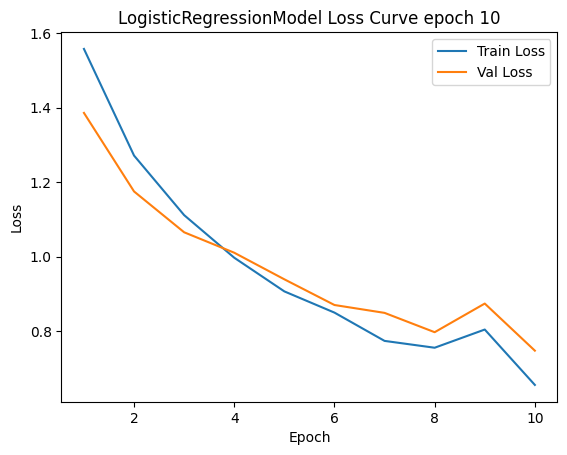

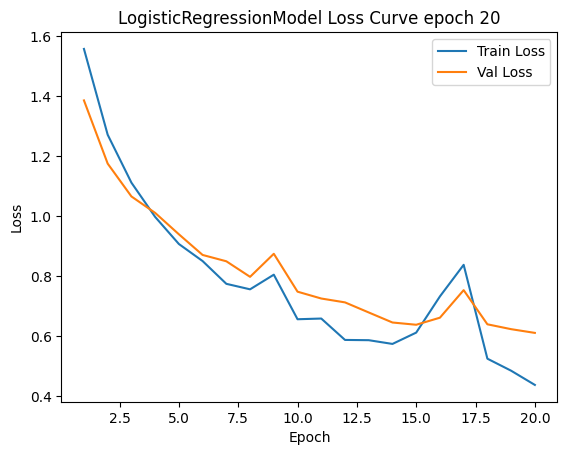

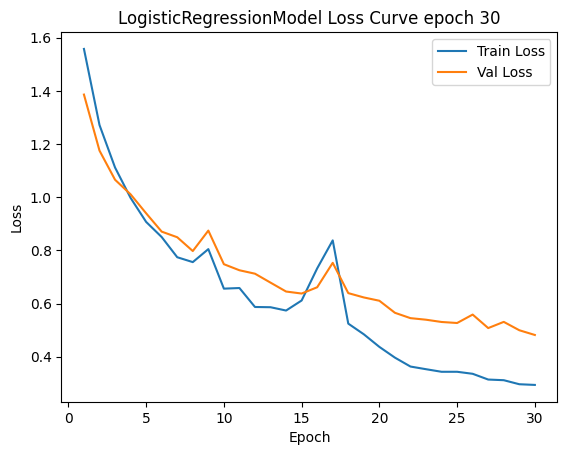

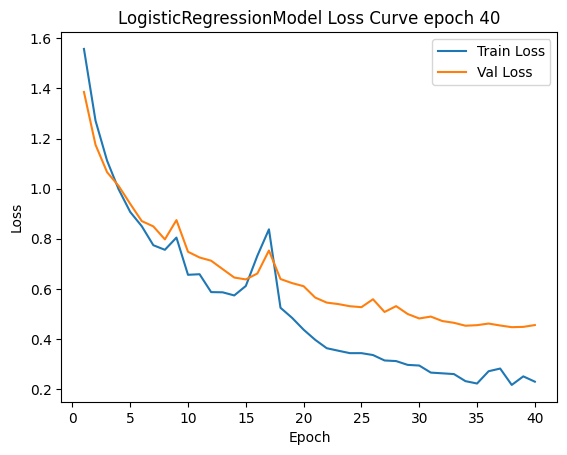

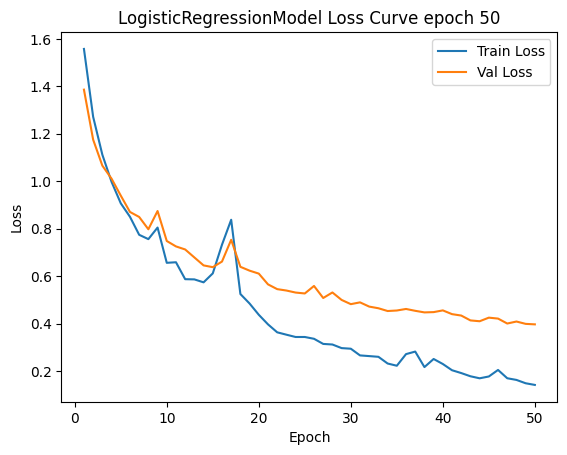

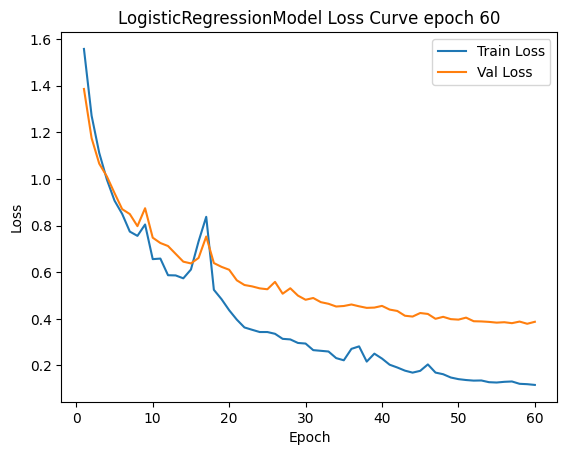

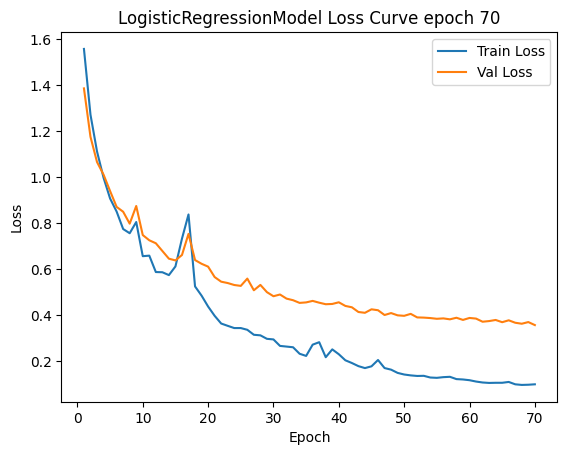

早停在第80个epoch
训练时间: 1154.15秒
训练完成，共训练80个epoch,LogisticRegressionModel的损失曲线如下：


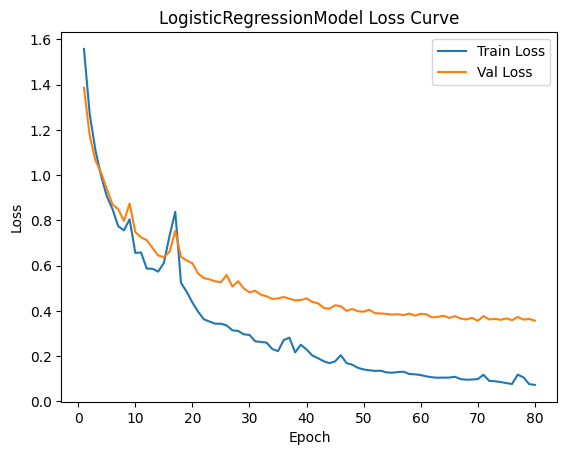

In [ ]:
#定义训练相关超参数
epochs=300
patience=10
delta=0.0001

#训练函数
def train(model,optimizer,criterion,model_name,train_loader=train_loader,val_loader=val_loader):
    start_time=time.time()
    best_loss=float('inf')
    early_stop_count=0
    train_losses=[]
    val_losses=[]
    for epoch in range(1,epochs+1):
        model.train()
        train_loss=0
        for img,label in train_loader:
            img=img.to(device)
            label=label.to(device).long()
            #前向传播
            output=model(img)
            #计算损失
            loss=criterion(output,label)
            #反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #累计损失
            train_loss+=loss.item()
        #计算每个epoch的平均损失
        train_loss/=len(train_loader)
        train_losses.append(train_loss)

        #早停
        #验证模型
        model.eval()
        val_loss=0
        with torch.no_grad():
            for img,label in val_loader:
                img=img.to(device)
                label=label.to(device).long()
                #前向传播
                output=model(img)
                #计算损失
                loss=criterion(output,label)
                #累计损失
                val_loss+=loss.item()
        #计算每个epoch的平均损失
        val_loss/=len(val_loader)
        val_losses.append(val_loss)
        #早停判断
        if val_loss<best_loss-delta:
            best_loss=val_loss
            early_stop_count=0
            #保存最佳模型
            model_path=os.path.join(save_path,f'{model_name}.pth')
            #筛选未冻结的参数(服务于后续导入预训练模型)⭐⭐⭐⭐⭐
            finetuned_params = {name: param for name, param in model.named_parameters() if param.requires_grad}
            torch.save(finetuned_params,model_path)
        else:
            early_stop_count+=1
        if early_stop_count>=patience:
            print(f"早停在第{epoch}个epoch")
            end_time=time.time()
            training_time=end_time-start_time
            print(f"训练时间: {training_time:.2f}秒")
            break

        #间隔一定轮数绘制损失曲线
        if epoch % 10 ==0:
            plt.plot(range(1,epoch+1),train_losses,label='Train Loss')
            plt.plot(range(1,epoch+1),val_losses,label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'{model_name} Loss Curve epoch {epoch}')
            plt.legend()
            plt.show()
    #绘制整个训练的损失曲线图
    print(f"训练完成，共训练{epoch}个epoch,{model_name}的损失曲线如下：")
    plt.plot(range(1,epoch+1),train_losses,label='Train Loss')
    plt.plot(range(1,epoch+1),val_losses,label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.legend()
    plt.show()
    print("="*100)

#训练模型
train(model,optimizer,criterion,model_name)

### 2.3 测试逻辑回归模型

In [ ]:
def test(model,model_name,test_loader=test_loader):
    model.to(device)
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)
            label = label.to(device).long()

            logits = model(img)                 # [B, 6]
            pred = logits.argmax(dim=1)         # [B]

            y_true.append(label.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    #打印测试结果
    print('The test Result of',model_name)
    print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4,target_names=class_name))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

#载入模型参数
model_path=os.path.join(save_path,f'{model_name}.pth')
model.load_state_dict(torch.load(model_path,map_location=device,weights_only=True),strict=False) #strict=False表示允许加载部分参数⭐
#测试模型
test(model,model_name)

The test Result of LogisticRegressionModel

Test Accuracy: 0.8947368421052632

Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.9375    0.8824    0.9091        17
            Clean     0.9412    0.8889    0.9143        18
            Dusty     0.8571    0.7500    0.8000        16
Electrical-damage     0.9231    0.9231    0.9231        13
  Physical-Damage     0.9375    1.0000    0.9677        15
     Snow-Covered     0.7895    0.9375    0.8571        16

         accuracy                         0.8947        95
        macro avg     0.8976    0.8970    0.8952        95
     weighted avg     0.8978    0.8947    0.8941        95


Confusion Matrix:
[[15  0  1  0  0  1]
 [ 0 16  0  1  0  1]
 [ 1  0 12  0  1  2]
 [ 0  1  0 12  0  0]
 [ 0  0  0  0 15  0]
 [ 0  0  1  0  0 15]]


## 3 决策树模型

### 3.1 构建决策树模型

In [6]:
clf = DecisionTreeClassifier(
    criterion="gini",     # 选择CART决策树
    max_depth=20,         # 设置树的最大深度，防止严重过拟合
    random_state=42
)

### 3.2 训练决策树模型

In [ ]:
clf.fit(X_train, y_train) #sklearn中的模型是采用fit方法进行训练⭐

,criterion,'gini'
,splitter,'best'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 3.3 在验证集上评估决策树模型

In [8]:
y_val_pred = clf.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(
    y_val,
    y_val_pred,
    target_names=train_dataset.classes,
    digits=4
))

Validation Accuracy: 0.9090909090909091

Validation Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.8649    0.9231    0.8930       104
            Clean     0.9375    0.8824    0.9091       102
            Dusty     0.9333    0.8660    0.8984        97
Electrical-damage     0.8537    0.9091    0.8805        77
  Physical-Damage     0.9250    0.9487    0.9367        78
     Snow-Covered     0.9451    0.9348    0.9399        92

         accuracy                         0.9091       550
        macro avg     0.9099    0.9107    0.9096       550
     weighted avg     0.9108    0.9091    0.9092       550



### 3.4 在测试集上评估决策树模型

In [9]:
y_test_pred = clf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=train_dataset.classes,
    digits=4
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.8631578947368421

Test Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.7000    0.8235    0.7568        17
            Clean     0.9333    0.7778    0.8485        18
            Dusty     1.0000    0.7500    0.8571        16
Electrical-damage     0.8571    0.9231    0.8889        13
  Physical-Damage     0.9375    1.0000    0.9677        15
     Snow-Covered     0.8333    0.9375    0.8824        16

         accuracy                         0.8632        95
        macro avg     0.8769    0.8686    0.8669        95
     weighted avg     0.8762    0.8632    0.8636        95


Confusion Matrix:
[[14  1  0  1  0  1]
 [ 2 14  0  1  1  0]
 [ 3  0 12  0  0  1]
 [ 0  0  0 12  0  1]
 [ 0  0  0  0 15  0]
 [ 1  0  0  0  0 15]]


## 4 支持向量机

### 4.1 构建支持向量机

In [ ]:
svc=SVC(kernel="rbf",gamma="scale",random_state=42)  #选择非线性的高斯核函数⭐

### 4.2 训练支持向量机

In [11]:
svc.fit(X_train,y_train) #sklearn中的模型是采用fit方法进行训练

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### 4.3 在验证集上评估支持向量机模型

In [12]:
y_val_pred = svc.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(
    y_val,
    y_val_pred,
    target_names=train_dataset.classes,
    digits=4
))

Validation Accuracy: 0.850909090909091

Validation Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.8241    0.8558    0.8396       104
            Clean     0.7876    0.8725    0.8279       102
            Dusty     0.8043    0.7629    0.7831        97
Electrical-damage     0.8421    0.8312    0.8366        77
  Physical-Damage     0.9692    0.8077    0.8811        78
     Snow-Covered     0.9271    0.9674    0.9468        92

         accuracy                         0.8509       550
        macro avg     0.8591    0.8496    0.8525       550
     weighted avg     0.8542    0.8509    0.8509       550



### 4.4 在测试集上评估支持向量机模型

In [13]:
y_test_pred = svc.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=train_dataset.classes,
    digits=4
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.8526315789473684

Test Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.7895    0.8824    0.8333        17
            Clean     0.7778    0.7778    0.7778        18
            Dusty     0.8571    0.7500    0.8000        16
Electrical-damage     0.9167    0.8462    0.8800        13
  Physical-Damage     0.8667    0.8667    0.8667        15
     Snow-Covered     0.9412    1.0000    0.9697        16

         accuracy                         0.8526        95
        macro avg     0.8582    0.8538    0.8546        95
     weighted avg     0.8538    0.8526    0.8518        95


Confusion Matrix:
[[15  0  1  0  1  0]
 [ 1 14  1  1  1  0]
 [ 2  1 12  0  0  1]
 [ 0  2  0 11  0  0]
 [ 1  1  0  0 13  0]
 [ 0  0  0  0  0 16]]


## 5 自定义卷积神经网络

### 5.1 构建卷积神经网络

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        # 第一层卷积层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()  

        # 第二层卷积层
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()  

        # 第三层卷积层
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()  

        # 全连接层
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # 调整为展平后的大小
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # 第一层
        x = self.relu1(self.bn1(self.conv1(x))) # 64x32x32

        # 第二层
        x = self.relu2(self.bn2(self.conv2(x))) # 128x16x16

        # 第三层
        x = self.relu3(self.bn3(self.conv3(x))) # 256x8x8

        # 展平并通过全连接层
        x = x.reshape(x.size(0), -1)  # 展平操作
        x = self.relu3(self.fc1(x))  # 使用ReLU激活
        x = self.fc2(x)
        
        return x

#定义模型相关超参数
num_classes= 6
lr=0.001
#初始化模型、损失函数、优化器
model=CNN(num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_name="CNN"

### 5.2 训练卷积神经网络，复用逻辑回归处的训练函数

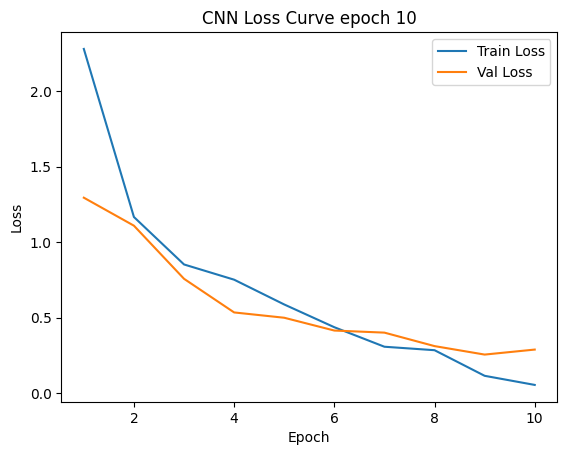

早停在第19个epoch
训练时间: 314.18秒
训练完成，共训练19个epoch,CNN的损失曲线如下：


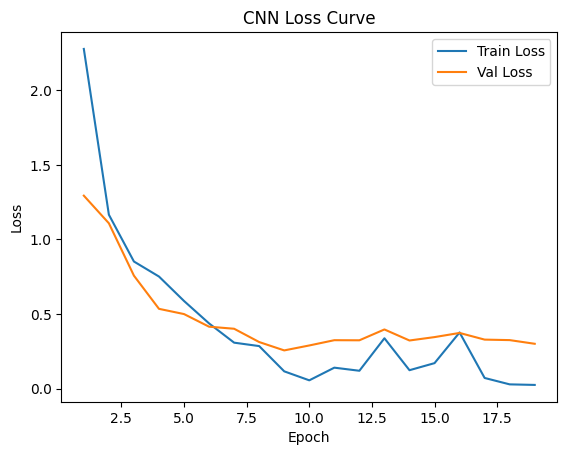

In [15]:
#定义训练相关超参数
epochs=300
patience=10
delta=0.0001

#训练模型
train(model,optimizer,criterion,model_name)

### 5.3 测试卷积神经网络，复用逻辑回归处的测试函数

In [16]:
#载入模型参数
model_path=os.path.join(save_path,f'{model_name}.pth')
model.load_state_dict(torch.load(model_path,map_location=device,weights_only=True),strict=False)
#测试模型
test(model,model_name)

The test Result of CNN

Test Accuracy: 0.9052631578947369

Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     1.0000    0.8824    0.9375        17
            Clean     0.8889    0.8889    0.8889        18
            Dusty     0.7619    1.0000    0.8649        16
Electrical-damage     0.9231    0.9231    0.9231        13
  Physical-Damage     0.9333    0.9333    0.9333        15
     Snow-Covered     1.0000    0.8125    0.8966        16

         accuracy                         0.9053        95
        macro avg     0.9179    0.9067    0.9074        95
     weighted avg     0.9178    0.9053    0.9065        95


Confusion Matrix:
[[15  0  1  0  1  0]
 [ 0 16  2  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  1  0 12  0  0]
 [ 0  1  0  0 14  0]
 [ 0  0  2  1  0 13]]


## 6 预训练的经典CNN架构

### 6.1 重新设置数据集参数————预训练的VGG、ResNet、AlexNet均是面向224x224的图像

In [ ]:
#定义图像变换
transform = transforms.Compose([
    transforms.Resize((224, 224)),     #统一图像尺寸为224，适配预训练的模型⭐⭐⭐
    transforms.ToTensor(),                       #将图像转换为张量，且将像素值归一化到[0,1]，不需要手动除255
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )                                            #设置图像归一化参数，此处直接使用ImageNet的均值和标准差
])
#加载训练数据集
train_dataset_new = datasets.ImageFolder(root="data/train",transform=transform)
#加载验证数据集
val_dataset_new = datasets.ImageFolder(root="data/val",transform=transform)
#加载测试数据集
test_dataset_new = datasets.ImageFolder(root="data/test",transform=transform)

#创建训练数据加载器
train_loader_new = DataLoader(train_dataset_new,batch_size=batch_size,shuffle=True)
#创建验证数据加载器
val_loader_new = DataLoader(val_dataset_new,batch_size=batch_size,shuffle=False)
#创建测试数据加载器
test_loader_new = DataLoader(test_dataset_new,batch_size=batch_size,shuffle=False)


### 6.2 加载预训练的VGG、ResNet、AlexNet

In [ ]:
num_calsses=6
model_list=[]
model_name_list=[]
optimizer_list=[]

#加载预训练的VGG
model=models.vgg16(pretrained=True)
#冻结所有层的参数⭐⭐⭐
for param in model.parameters():
    param.requires_grad=False
#修改最后一层的分类数⭐⭐⭐
model.classifier[6]=nn.Linear(model.classifier[6].in_features,num_classes)
#解冻最后一层的参数⭐⭐⭐
for param in model.classifier[6].parameters():
    param.requires_grad=True
#定义优化器：只优化最后一层的参数⭐⭐⭐
optimizer=torch.optim.Adam(model.classifier[6].parameters(),lr=0.001)
model.to(device)
#将模型添加到模型列表中
model_list.append(model)
model_name_list.append('VGG16')
optimizer_list.append(optimizer)

#加载预训练的ResNet
model=models.resnet18(pretrained=True)
#冻结所有层的参数⭐⭐⭐
for param in model.parameters():
    param.requires_grad=False
#修改最后一层的分类数⭐⭐⭐
model.fc=nn.Linear(model.fc.in_features,num_classes)
#解冻最后一层的参数⭐⭐⭐
for param in model.fc.parameters():
    param.requires_grad=True
#定义优化器：只优化最后一层的参数⭐⭐⭐
optimizer=torch.optim.Adam(model.fc.parameters(),lr=0.001)
model.to(device)
#将模型添加到模型列表中
model_list.append(model)
model_name_list.append('ResNet18')
optimizer_list.append(optimizer)

#加载预训练的AlexNet
model=models.alexnet(pretrained=True)
#冻结所有层的参数⭐⭐⭐
for param in model.parameters():
    param.requires_grad=False
#修改最后一层的分类数⭐⭐⭐
model.classifier[6]=nn.Linear(model.classifier[6].in_features,num_classes)
#解冻最后一层的参数⭐⭐⭐
for param in model.classifier[6].parameters():
    param.requires_grad=True
#定义优化器：只优化最后一层的参数⭐⭐⭐
optimizer=torch.optim.Adam(model.classifier[6].parameters(),lr=0.001)
model.to(device)
#将模型添加到模型列表中
model_list.append(model)
model_name_list.append('AlexNet')
optimizer_list.append(optimizer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [01:04<00:00, 8.57MB/s] 


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:06<00:00, 7.59MB/s]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:31<00:00, 7.71MB/s] 


### 6.3 微调预训练的VGG、ResNet、AlexNet（复用逻辑回归处的训练函数）

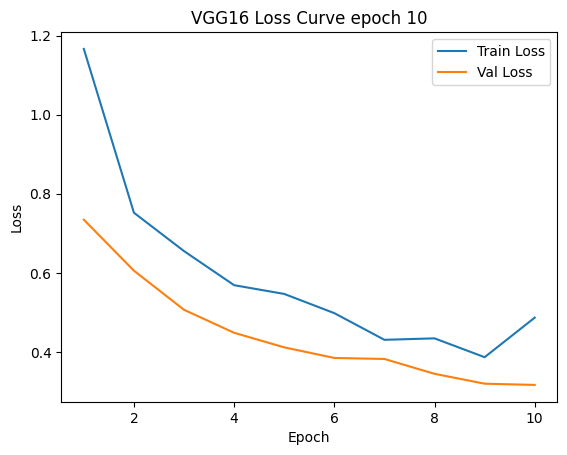

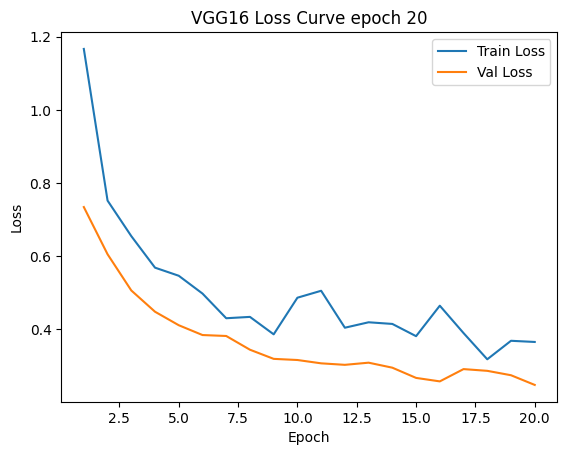

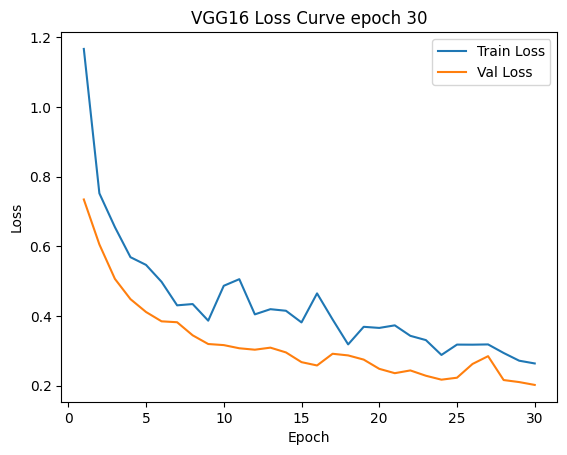

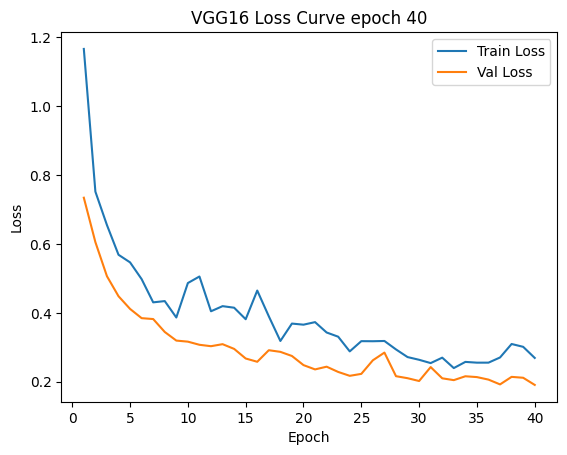

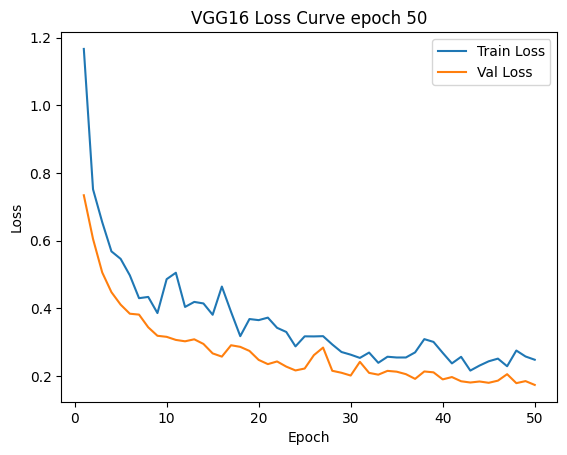

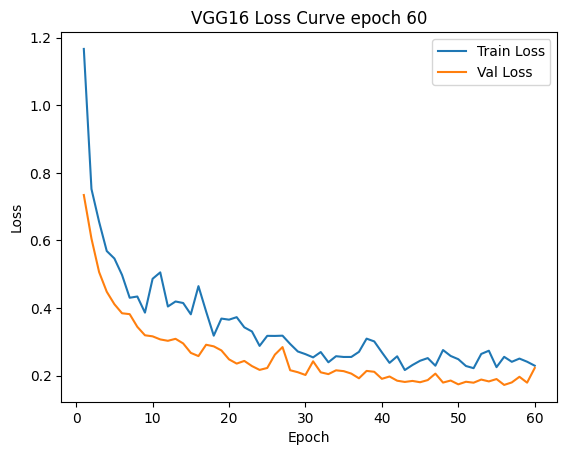

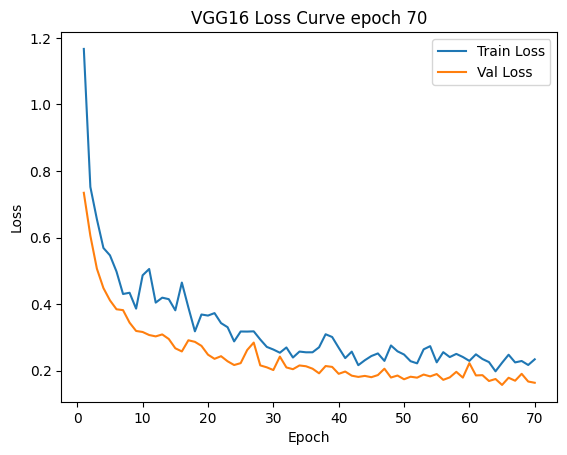

早停在第75个epoch
训练时间: 1601.90秒
训练完成，共训练75个epoch,VGG16的损失曲线如下：


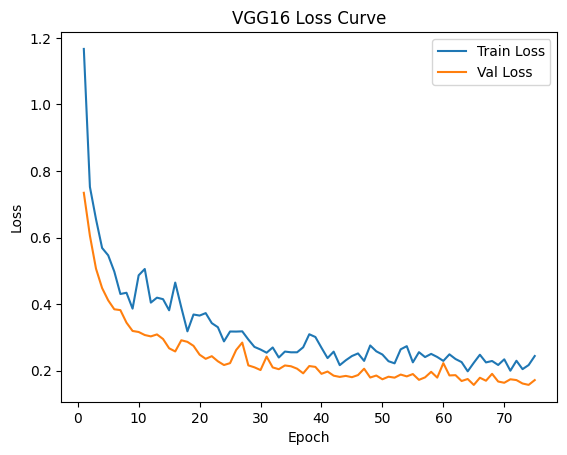

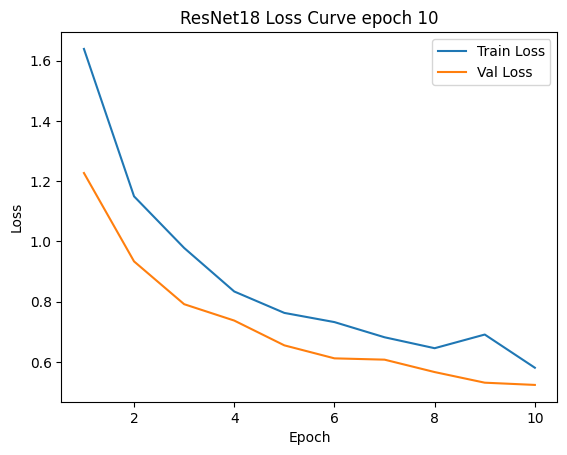

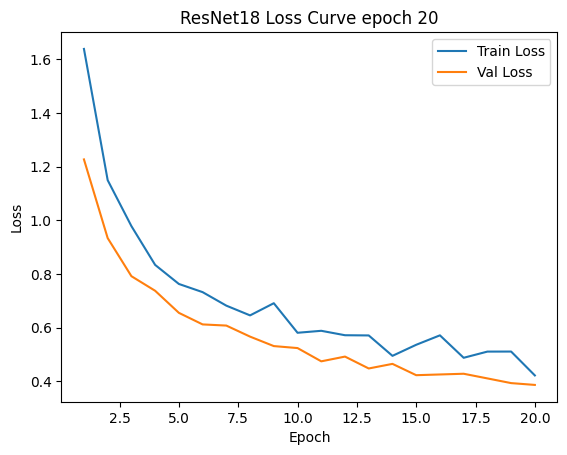

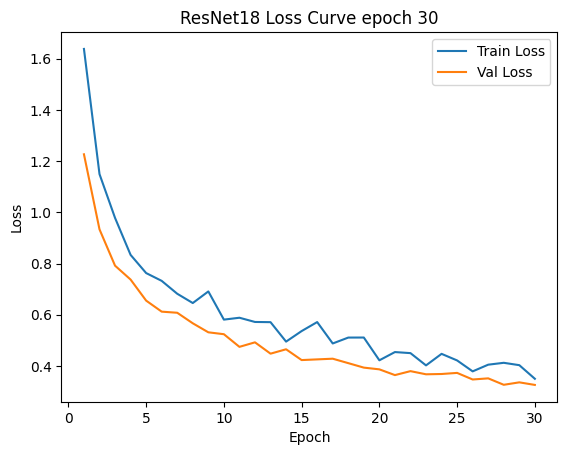

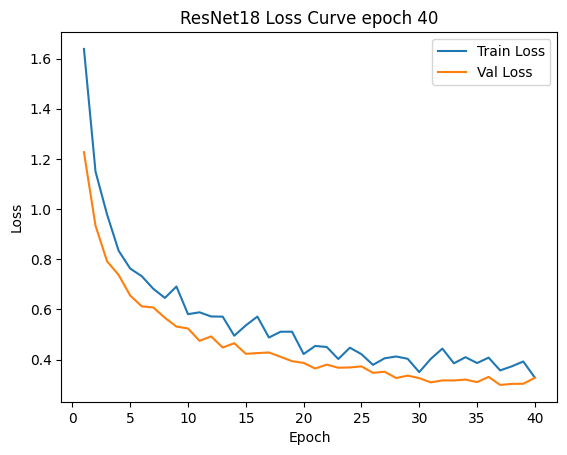

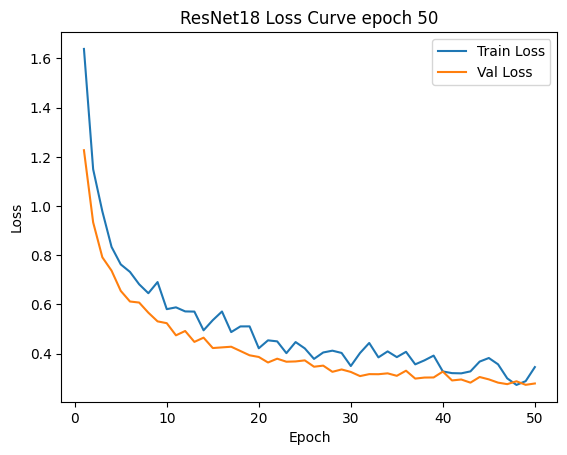

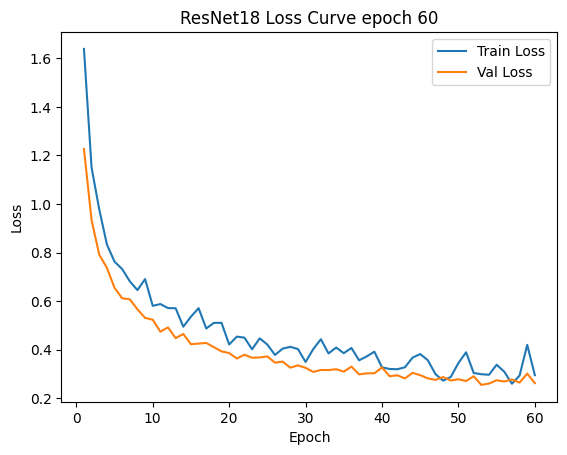

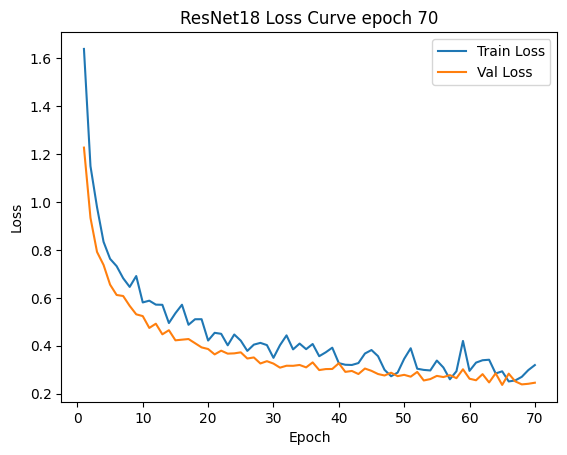

早停在第75个epoch
训练时间: 1438.00秒
训练完成，共训练75个epoch,ResNet18的损失曲线如下：


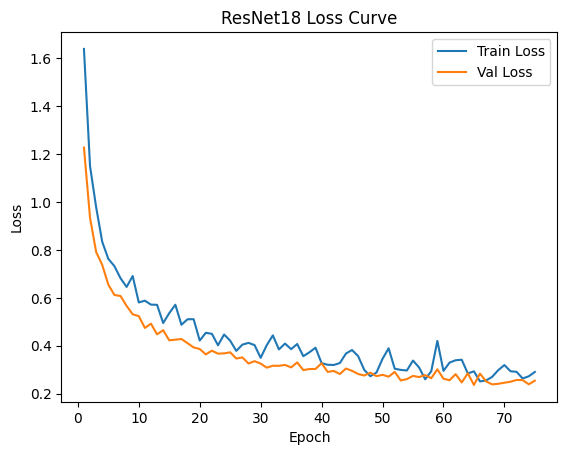

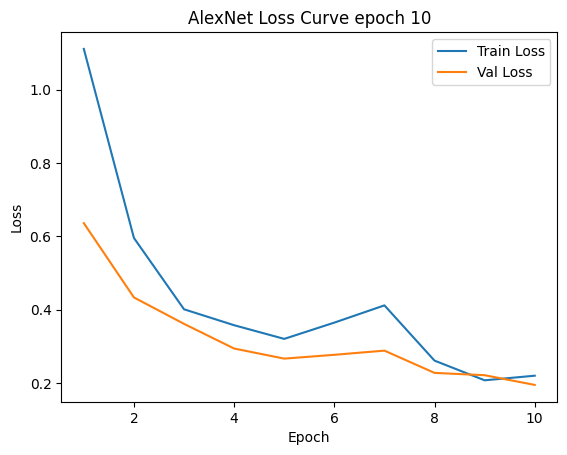

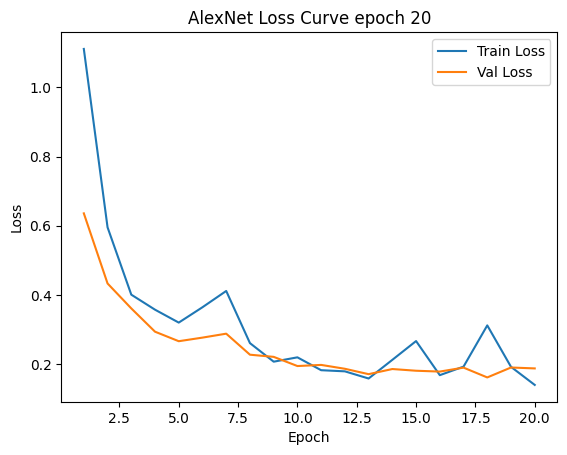

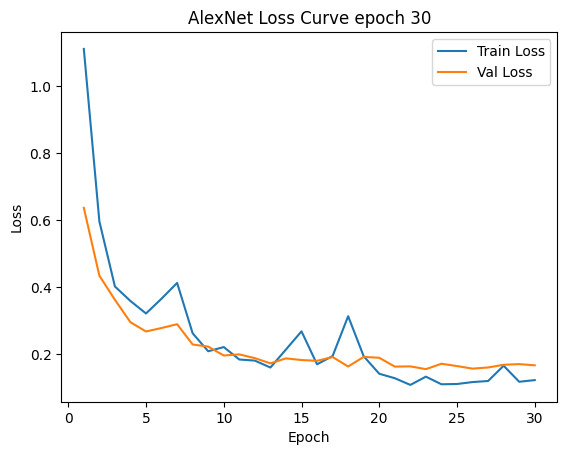

早停在第33个epoch
训练时间: 672.39秒
训练完成，共训练33个epoch,AlexNet的损失曲线如下：


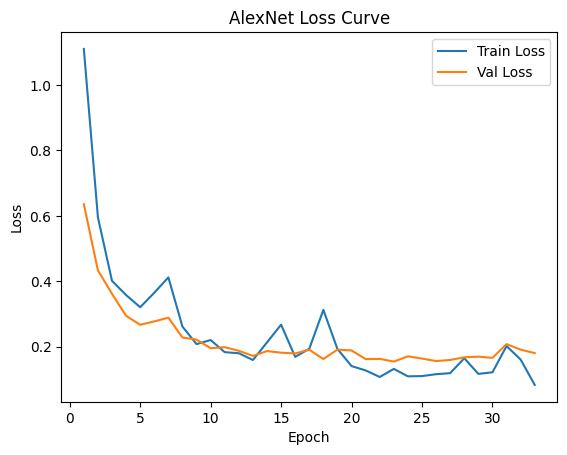

In [19]:
#微调模型
for model,optimizer,model_name in zip(model_list,optimizer_list,model_name_list):
    train(model,optimizer,criterion,model_name,train_loader_new,val_loader_new)

### 6.4 测试三类经典CNN模型（复用逻辑回归处的测试函数）

In [20]:
#载入模型参数
for model,model_name in zip(model_list,model_name_list):
    model_path=os.path.join(save_path,f'{model_name}.pth')
    model.load_state_dict(torch.load(model_path,map_location=device,weights_only=True),strict=False)
    model.eval()
    #测试
    test(model,model_name,test_loader_new)

The test Result of VGG16

Test Accuracy: 0.9263157894736842

Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.8947    1.0000    0.9444        17
            Clean     0.9375    0.8333    0.8824        18
            Dusty     0.8667    0.8125    0.8387        16
Electrical-damage     0.8667    1.0000    0.9286        13
  Physical-Damage     1.0000    0.9333    0.9655        15
     Snow-Covered     1.0000    1.0000    1.0000        16

         accuracy                         0.9263        95
        macro avg     0.9276    0.9299    0.9266        95
     weighted avg     0.9286    0.9263    0.9254        95


Confusion Matrix:
[[17  0  0  0  0  0]
 [ 0 15  2  1  0  0]
 [ 2  1 13  0  0  0]
 [ 0  0  0 13  0  0]
 [ 0  0  0  1 14  0]
 [ 0  0  0  0  0 16]]
The test Result of ResNet18

Test Accuracy: 0.9052631578947369

Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.9444  

## 7 集成学习

### 7.1 初始化随机森林、Adaboost模型、Stacking模型

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
# 初始化随机森林模型⭐
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
# 初始化Adaboost模型⭐
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
# 初始化Stacking模型⭐
stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
        ('ada', AdaBoostClassifier(n_estimators=50, random_state=42))
    ],
    final_estimator=LogisticRegression() # 逻辑回归模型作为元学习器
)

### 7.2 训练三类集成学习模型

In [54]:
# 训练随机森林模型
rf_model.fit(X_train, y_train)
# 训练Adaboost模型
ada_model.fit(X_train, y_train)
# 训练Stacking模型
stacking_model.fit(X_train, y_train)

,estimators,"[('rf', ...), ('ada', ...)]"
,final_estimator,LogisticRegression()
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2


### 7.3 在验证集上评估三类集成学习模型

In [55]:
#评估随机森林模型
y_val_pred = rf_model.predict(X_val)
print('The validation accuracy of random forest model is:')
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(
    y_val,
    y_val_pred,
    target_names=train_dataset.classes,
    digits=4
))
print('='*50)

#评估Adaboost模型
y_val_pred = ada_model.predict(X_val)
print('The validation accuracy of adaboost model is:')
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(
    y_val,
    y_val_pred,
    target_names=train_dataset.classes,
    digits=4
))
print('='*50)

#评估Stacking模型
y_val_pred = stacking_model.predict(X_val)
print('The validation accuracy of stacking model is:')
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(
    y_val,
    y_val_pred,
    target_names=train_dataset.classes,
    digits=4
))
print('='*50)

The validation accuracy of random forest model is:
Validation Accuracy: 0.9290909090909091

Validation Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.8909    0.9423    0.9159       104
            Clean     0.9029    0.9118    0.9073       102
            Dusty     0.9043    0.8763    0.8901        97
Electrical-damage     0.9733    0.9481    0.9605        77
  Physical-Damage     0.9865    0.9359    0.9605        78
     Snow-Covered     0.9468    0.9674    0.9570        92

         accuracy                         0.9291       550
        macro avg     0.9341    0.9303    0.9319       550
     weighted avg     0.9299    0.9291    0.9292       550

The validation accuracy of adaboost model is:
Validation Accuracy: 0.4636363636363636

Validation Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.3594    0.2212    0.2738       104
            Clean     0.4655    0.5294   

### 7.4 在测试集上评估三类集成学习模型

In [56]:
#测试随机森林模型
y_test_pred = rf_model.predict(X_test)
print('The test accuracy of random forest model is:')
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=train_dataset.classes,
    digits=4
))
print('='*50)

#测试Adaboost模型
y_test_pred = ada_model.predict(X_test)
print('The test accuracy of adaboost model is:')
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=train_dataset.classes,
    digits=4
))
print('='*50)

#测试Stacking模型
y_test_pred = stacking_model.predict(X_test)
print('The test accuracy of stacking model is:')
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=train_dataset.classes,
    digits=4
))
print('='*50)


The test accuracy of random forest model is:
Test Accuracy: 0.8947368421052632

Test Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.8333    0.8824    0.8571        17
            Clean     0.8824    0.8333    0.8571        18
            Dusty     0.8571    0.7500    0.8000        16
Electrical-damage     0.9286    1.0000    0.9630        13
  Physical-Damage     1.0000    0.9333    0.9655        15
     Snow-Covered     0.8889    1.0000    0.9412        16

         accuracy                         0.8947        95
        macro avg     0.8984    0.8998    0.8973        95
     weighted avg     0.8953    0.8947    0.8933        95

The test accuracy of adaboost model is:
Test Accuracy: 0.5052631578947369

Test Classification Report:
                   precision    recall  f1-score   support

        Bird-drop     0.3000    0.1765    0.2222        17
            Clean     0.5556    0.5556    0.5556        18
            Dusty 